## Where and When Should I Not Be Parking Illegally in NYC?

In [1]:
import os
import pandas as pd
import geopandas as gpd
import subprocess
from geopandas.tools import geocode
import re
from matplotlib import pyplot as plt

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_folder = '/Users/geoffperrin/Desktop/python_sandbox/NYPD/data'

### Read in NYPD parking data

In [3]:
'''
taken from:
https://data.cityofnewyork.us/Social-Services/nypd-7-major-felony-incidents/k384-xu3q/data
filtered to Agency: NYPD
Complaint Type: Illegal Parking
'''

nypd_df_raw = pd.read_csv(data_folder+'/nypd_7_major_felony_incidents.csv')
nypd_df = nypd_df_raw[['Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', \
                       'Community Board', 'Borough', 'Latitude', 'Longitude']]

#subset to just blocked sidewalks
nypd_df = nypd_df[nypd_df.Descriptor == "Blocked Sidewalk"]
nypd_df.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Community Board,Borough,Latitude,Longitude
9,09/04/2015 08:52:01 PM,09/04/2015 11:24:31 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,05 QUEENS,QUEENS,40.722005,-73.904019
37,09/04/2015 04:43:36 PM,09/04/2015 10:15:45 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,03 STATEN ISLAND,STATEN ISLAND,40.562832,-74.148151
46,09/04/2015 08:46:01 AM,09/04/2015 12:14:42 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,02 STATEN ISLAND,STATEN ISLAND,40.593806,-74.075633
54,09/05/2015 12:03:41 AM,NaN,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,0 Unspecified,Unspecified,NaN,NaN
57,09/04/2015 07:17:15 PM,09/05/2015 02:51:48 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,01 BROOKLYN,BROOKLYN,40.713757,-73.936055


In [4]:
nypd_df['create_date_time'] = pd.to_datetime(nypd_df['Created Date'])
nypd_df['closed_date_time'] = pd.to_datetime(nypd_df['Closed Date'])

In [5]:
nypd_df['create_date'] = nypd_df['create_date_time'].dt.date
nypd_df['day_of_week'] = nypd_df.create_date.apply(lambda x: x.weekday())

#control for Friday / Saturday nights
nypd_df['weekend'] = 0
nypd_df['weekend'][(nypd_df['day_of_week'] == 4) | (nypd_df['day_of_week'] == 5)] = 1

#control for hour of day
nypd_df['hour_of_day'] = nypd_df.create_date_time.apply(lambda x: x.hour)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
nypd_df.sort(['create_date_time']).head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Community Board,Borough,Latitude,Longitude,create_date_time,closed_date_time,create_date,day_of_week,weekend,hour_of_day
133642,06/03/2010 03:41:11 PM,06/03/2010 04:49:08 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,05 MANHATTAN,MANHATTAN,40.762334,-73.980370,2010-06-03 15:41:11,2010-06-03 16:49:08,2010-06-03,3,0,15
133666,06/03/2010 04:09:26 PM,06/03/2010 04:23:23 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,06 MANHATTAN,MANHATTAN,40.747629,-73.976736,2010-06-03 16:09:26,2010-06-03 16:23:23,2010-06-03,3,0,16
133653,06/03/2010 05:41:12 PM,06/04/2010 07:18:51 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,01 STATEN ISLAND,STATEN ISLAND,40.618095,-74.086207,2010-06-03 17:41:12,2010-06-04 07:18:51,2010-06-03,3,0,17
133643,06/03/2010 07:14:56 PM,06/04/2010 12:21:08 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,09 MANHATTAN,MANHATTAN,40.814067,-73.960362,2010-06-03 19:14:56,2010-06-04 00:21:08,2010-06-03,3,0,19
133768,06/04/2010 06:55:34 AM,06/04/2010 11:06:31 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,18 BROOKLYN,BROOKLYN,40.639118,-73.910998,2010-06-04 06:55:34,2010-06-04 11:06:31,2010-06-04,4,1,6


### Time Series of Counts 

In [6]:
nypd_count_df = nypd_df.groupby(['create_date'], as_index=False)['Agency'].count()
nypd_count_df.columns = ['create_date', 'sidewalk_parking_count']

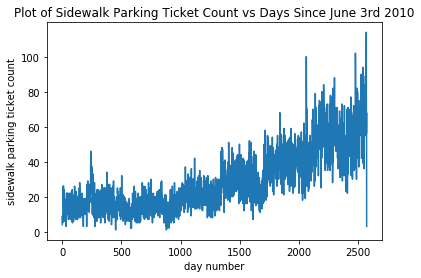

In [33]:
plt.plot(nypd_count_df[['sidewalk_parking_count']])
plt.xlabel('day number')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Days Since June 3rd 2010')

### Count by Hour of Day

In [9]:
nypd_hour_df = nypd_df.groupby(['hour_of_day'], as_index=False)['Agency'].count()
nypd_hour_df.columns = ['hour_of_day', 'sidewalk_parking_count']

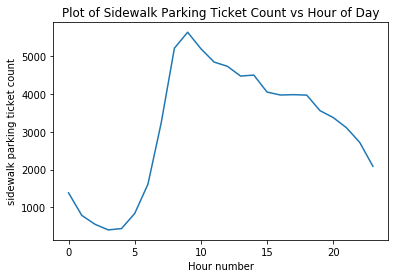

In [34]:
plt.plot(nypd_hour_df[['sidewalk_parking_count']])
plt.xlabel('Hour number')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Hour of Day')

### Count by Day of Week

In [11]:
nypd_day_df = nypd_df.groupby(['day_of_week'], as_index=False)['Agency'].count()
nypd_day_df.columns = ['day_of_week', 'sidewalk_parking_count']

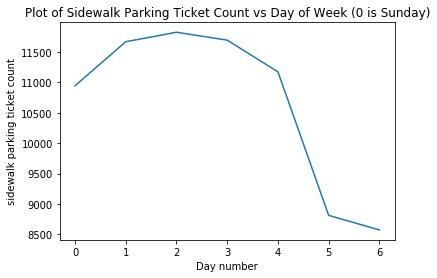

In [37]:
plt.plot(nypd_day_df[['sidewalk_parking_count']])
plt.xlabel('Day number')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Day of Week (0 is Sunday)')

### Read in ACS Data

In [13]:
'''
taken from: 
https://public.enigma.com/datasets/household-size-by-vehicles-available/f9d2a838-00ce-4d17-90bb-9a20e22f515a?filter=%2B%5B%3Estusab%5BNY%5D%5D
'''
acs_df_raw = pd.read_csv(data_folder+'/ACS_vehicle_data.csv')
#subset to just NYC
acs_df = acs_df_raw[(acs_df_raw.b08201_001 == "795") & (acs_df_raw.sumlevel == "NY")]
acs_nyc_df = acs_df[acs_df['name'].str.contains("NYC")]
acs_nyc_df = acs_nyc_df.iloc[:,0:17]
acs_nyc_df.columns = ['name', 'name2', 'geoid', 'state', 'summary_level', 'total_pop',\
                     'total_pop_moe', 'no_vehicle_pop', 'no_vehicle_pop_moe',\
                     'one_vehicle_pop', 'one_vehicle_pop_moe', 'two_vehicle_pop',\
                     'two_vehicle_pop_moe', 'three_vehicle_pop', 'three_vehicle_pop_moe',\
                     'four_or_more_vehicle_pop', 'four_or_more_vehicle_pop_moe']
#acs_nyc_df = acs_nyc_df[acs_nyc_df.total_pop!="None"]

### Do a little regex stuff to get useable x-walk for community district name

In [14]:
# Harmonize community district name for ACS

dict_boro2 = {'Bronx': 'BX', 'Brooklyn': 'BK', 'Manhattan': 'MN', 'Staten': 'SI', 'Queens': 'QN'}

def add_zero(f):
    if len(f) == 1:
        return '0'+f
    else:
        return f

acs_nyc_df['cd_num'] = [re.search("[0-9]+", i).group(0) for i in acs_nyc_df['name']]
acs_nyc_df['cd_num_2'] = [add_zero(i) for i in acs_nyc_df['cd_num']]

acs_nyc_df['boro'] = [dict_boro2[re.search('[^\s]+', i[4:]).group(0)] for i in acs_nyc_df['name']]

acs_nyc_df['cd_id'] = acs_nyc_df['boro'] + acs_nyc_df['cd_num_2']

In [15]:
acs_nyc_df = acs_nyc_df.replace(to_replace="None", value=0)

In [16]:
acs_nyc_df = acs_nyc_df.replace(to_replace="None", value=0)
acs_nyc_df = acs_nyc_df[['cd_id', 'boro', 'total_pop', 'no_vehicle_pop', 'one_vehicle_pop', 'two_vehicle_pop', \
                         'three_vehicle_pop', 'four_or_more_vehicle_pop']]
acs_nyc_df['vehicle_pop'] = acs_nyc_df['one_vehicle_pop'].astype(int) + 2*acs_nyc_df['two_vehicle_pop'].astype(int) + \
                            3*acs_nyc_df['three_vehicle_pop'].astype(int) + 4*acs_nyc_df['four_or_more_vehicle_pop'].astype(int)

acs_nyc_df['total_pop'] = acs_nyc_df['total_pop'].astype(int)
acs_nyc_df = acs_nyc_df[['cd_id', 'boro', 'total_pop', 'vehicle_pop']]
acs_nyc_df.head()

,cd_id,boro,total_pop,vehicle_pop
3252,MN06,MN,0,0
4426,BX08,BX,41340,31602
4427,BX12,BX,47321,38848
4428,BX10,BX,47025,43162
4429,BX11,BX,43622,34441


### Merge ACS data to NYPD data

In [17]:
nypd_cd_df = nypd_df.groupby(['Community Board'], as_index=False)['Agency'].count()
nypd_cd_df.columns = ['community_board', 'sidewalk_parking_count']

In [18]:
nypd_cd_df['cd_num'] = nypd_cd_df['community_board'].str.split(' ', 1).str[0]
nypd_cd_df['cd_boro'] = nypd_cd_df['community_board'].str.split(' ', 1).str[1]

In [19]:
# Harmonize identifier

dict_boro = {'BRONX': 'BX', 'BROOKLYN': 'BK', 'MANHATTAN': 'MN', 'STATEN ISLAND': 'SI', 'QUEENS': 'QN'}

nypd_cd_df['cd_num'] = nypd_cd_df['community_board'].str.split(' ', 1).str[0]
nypd_cd_df['cd_boro'] = nypd_cd_df['community_board'].str.split(' ', 1).str[1]

nypd_cd_df['cd_id'] = nypd_cd_df['cd_boro'].map(dict_boro) + nypd_cd_df['cd_num']
nypd_cd_df = nypd_cd_df[['sidewalk_parking_count', 'cd_id']]

In [20]:
nypd_cd_acs_df = nypd_cd_df.merge(acs_nyc_df, on='cd_id', how='left')
nypd_cd_acs_df['boro'] = nypd_cd_acs_df['cd_id'].str[:2]
nypd_cd_acs_df = nypd_cd_acs_df.fillna(0)

In [21]:
#replace missing cd stats with boro averages
replace_df = nypd_cd_acs_df[nypd_cd_acs_df.total_pop > 0]
replace_df = replace_df.groupby(['boro'], as_index=False)['total_pop', 'vehicle_pop'].mean()

In [22]:
nypd_cd_acs_df = nypd_cd_acs_df.merge(replace_df, on='boro', how='left')

In [23]:
nypd_cd_acs_df['total_pop_x'] = np.where(nypd_cd_acs_df['total_pop_x'] == 0, nypd_cd_acs_df['total_pop_y'],\
                                          nypd_cd_acs_df['total_pop_x'])
nypd_cd_acs_df['vehicle_pop_x'] = np.where(nypd_cd_acs_df['vehicle_pop_x']==0, nypd_cd_acs_df['vehicle_pop_y'],\
                                            nypd_cd_acs_df['vehicle_pop_x'])
nypd_cd_acs_df = nypd_cd_acs_df[['cd_id', 'total_pop_x', 'vehicle_pop_x', 'sidewalk_parking_count']]
nypd_cd_acs_df.columns = ['cd_id', 'total_pop', 'vehicle_pop', 'sidewalk_parking_count']

In [24]:
nypd_cd_acs_df['pct_sidewalk_parking'] = nypd_cd_acs_df.sidewalk_parking_count * 1.0 / nypd_cd_acs_df.vehicle_pop

In [25]:
### drop bad community districts
nypd_cd_acs_df = nypd_cd_acs_df.dropna()
nypd_cd_acs_df = nypd_cd_acs_df[nypd_cd_acs_df.cd_id.str[2:]!="Unspecified"]
nypd_cd_acs_df = nypd_cd_acs_df[nypd_cd_acs_df['cd_id'].str[2:].astype(int)<=18]

In [26]:
# read in community district shapefile
'''
http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
'''
cd_raw = gpd.read_file(data_folder + '/nycd.shp')
cd_raw = cd_raw.to_crs(epsg=4326)

In [27]:
# Standardize community district code like before
'''
1 Manhattan (New York County)
2 Bronx (Bronx County)
3 Brooklyn (Kings County)
4 Queens (Queens County)
5 Staten Island (Richmond County)
'''
dict_boro_num = {'2': 'BX', '3': 'BK', '1': 'MN', '5': 'SI', '4': 'QN'}
cd_raw['cd_id'] = cd_raw.BoroCD.astype(str).str[:1].map(dict_boro_num) + cd_raw.BoroCD.astype(str).str[1:]

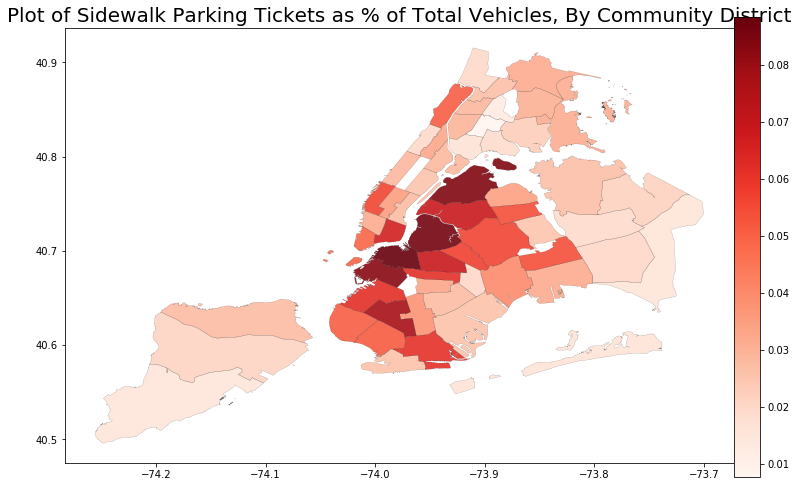

In [28]:
f, (ax1) = plt.subplots(figsize=(12,8))
cd_map = cd_raw.merge(nypd_cd_acs_df, on='cd_id')
cd_map.plot(column='pct_sidewalk_parking', cmap='Reds', alpha=.9, linewidth=0.1, ax=ax1)
ax1.set_title("Plot of Sidewalk Parking Tickets as % of Total Vehicles, By Community District",\
             fontsize=20)

vmin, vmax = min(cd_map.pct_sidewalk_parking.values),\
            max(cd_map.pct_sidewalk_parking.values)
    
fig = ax1.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

## Putting community district / hour / day of week / year all together
